# Machine Learning Model for Predicting DTSM

## Introduction
This notebook demonstrates the process of predicting DTSM using Neural Network. This task is part of my final exam in the Machine Learning in Geophysics class.
Key steps include:
1. Data loading and exploration
2. Features selection
3. Design the architecture of the neural network
4. Model training and evaluation
5. Prediction 

Neural Networks are chosen for this task due to their ability to model complex, nonlinear relationships in geophysical data.

## Prerequisites
To run this notebook, ensure you have the following libraries installed:
- `numpy`
- `pandas`
- `matplotlib`
- `seaborn`
- `scikit-learn`
- `tensorflow`

You can install them using:
```bash
pip install -r requirements.txt


### Note on Hardware
If using a large dataset or training complex neural networks, a GPU-enabled environment is recommended to speed up training. Ensure TensorFlow is configured to utilize your GPU.



In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data loading and exploration

In [26]:
data = pd.read_csv('../ML-Vs-prediction-main/data/UAS.csv')

data.shape
data.head()

DEPT     ECGR    ATRX    ATRT   NPHI    CAL1    HDAR    HROM      DTSM  \
0  4600.5  42.8228  3.5445  3.2769  12.40  6.0635  6.2070  2.5112  132.6781   
1  4601.0  60.1452  2.7997  2.6506  15.30  6.0765  6.2088  2.5277  135.1772   
2  4601.5  36.4007  2.8454  2.7274  12.28  6.0627  6.2070  2.5127  114.1906   
3  4602.0  35.3279  3.5764  3.4379  10.16  6.0711  6.2088  2.5271  114.2432   
4  4602.5  64.0310  3.5706  3.4355  10.93  6.0625  6.2088  2.5094  133.2964   

      DTCO  
0  80.4120  
1  82.5646  
2  72.5366  
3  70.7520  
4  79.0781

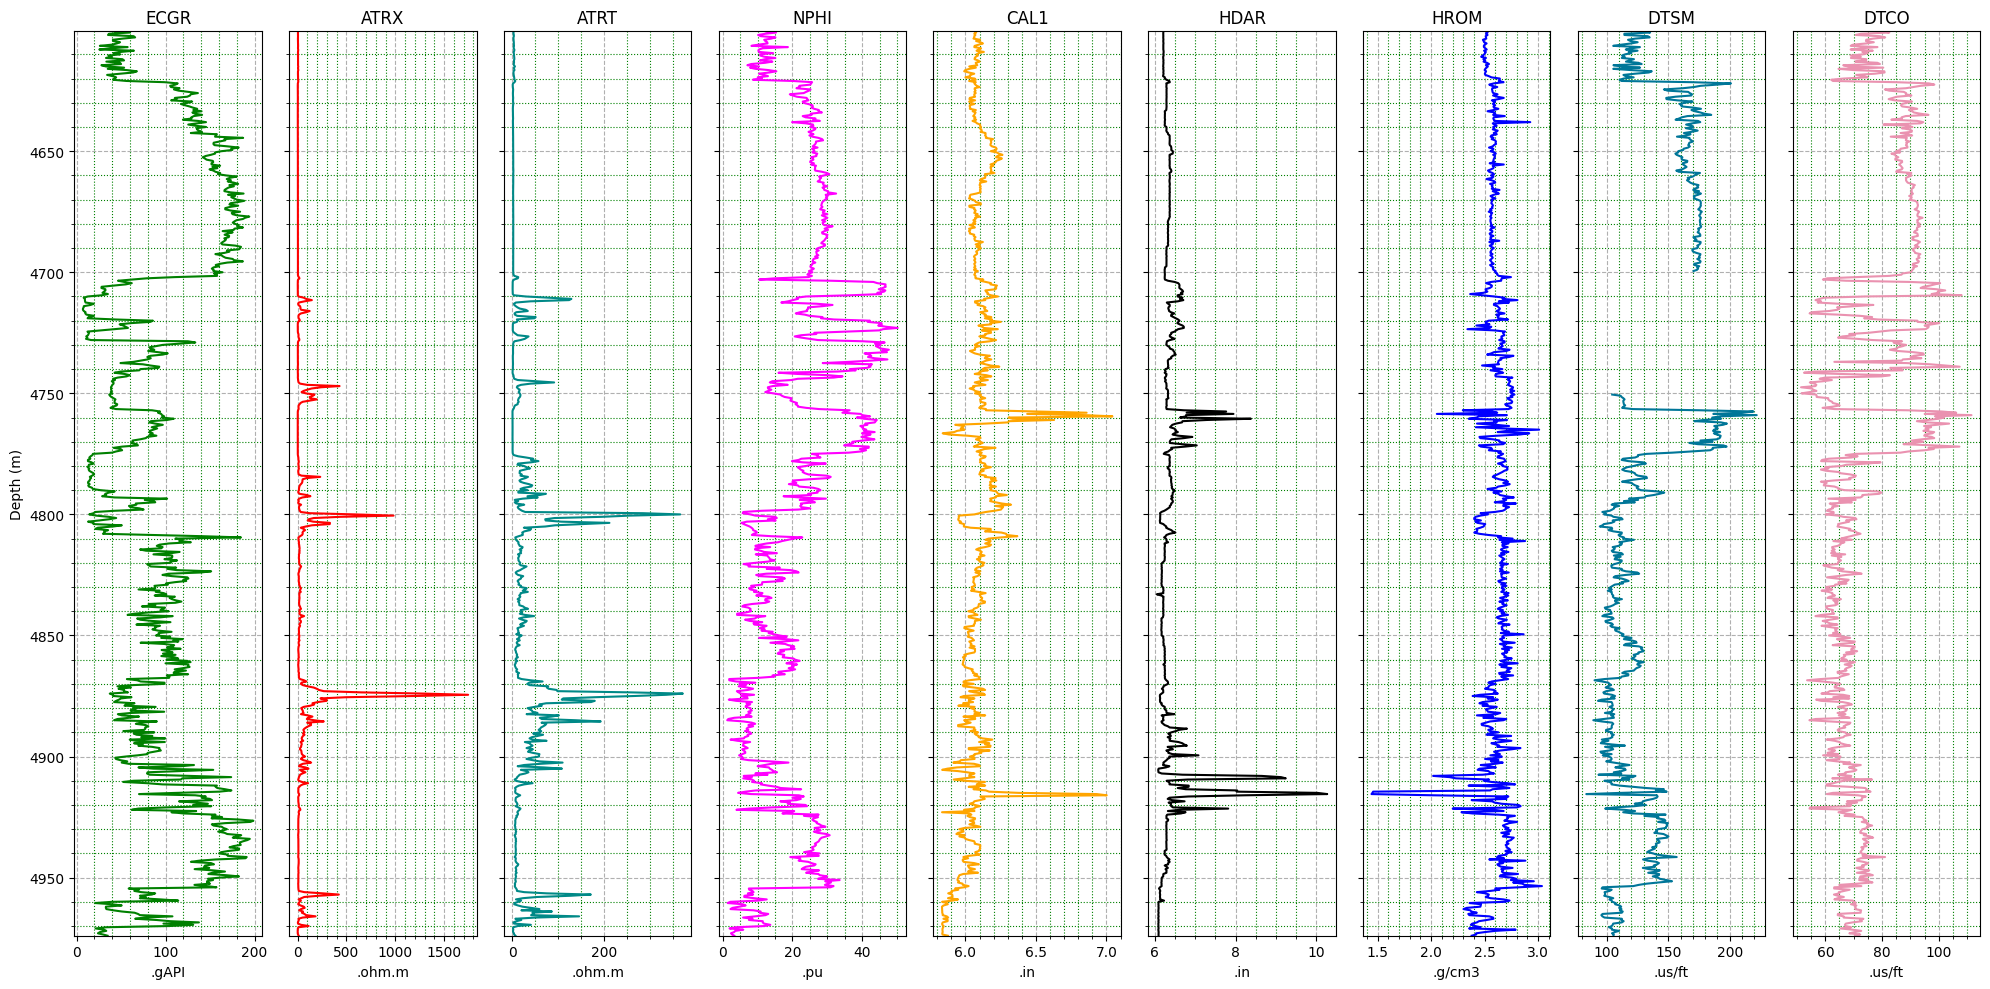

In [27]:
from plot import plot_log, plot_log_res
plot_log(data)

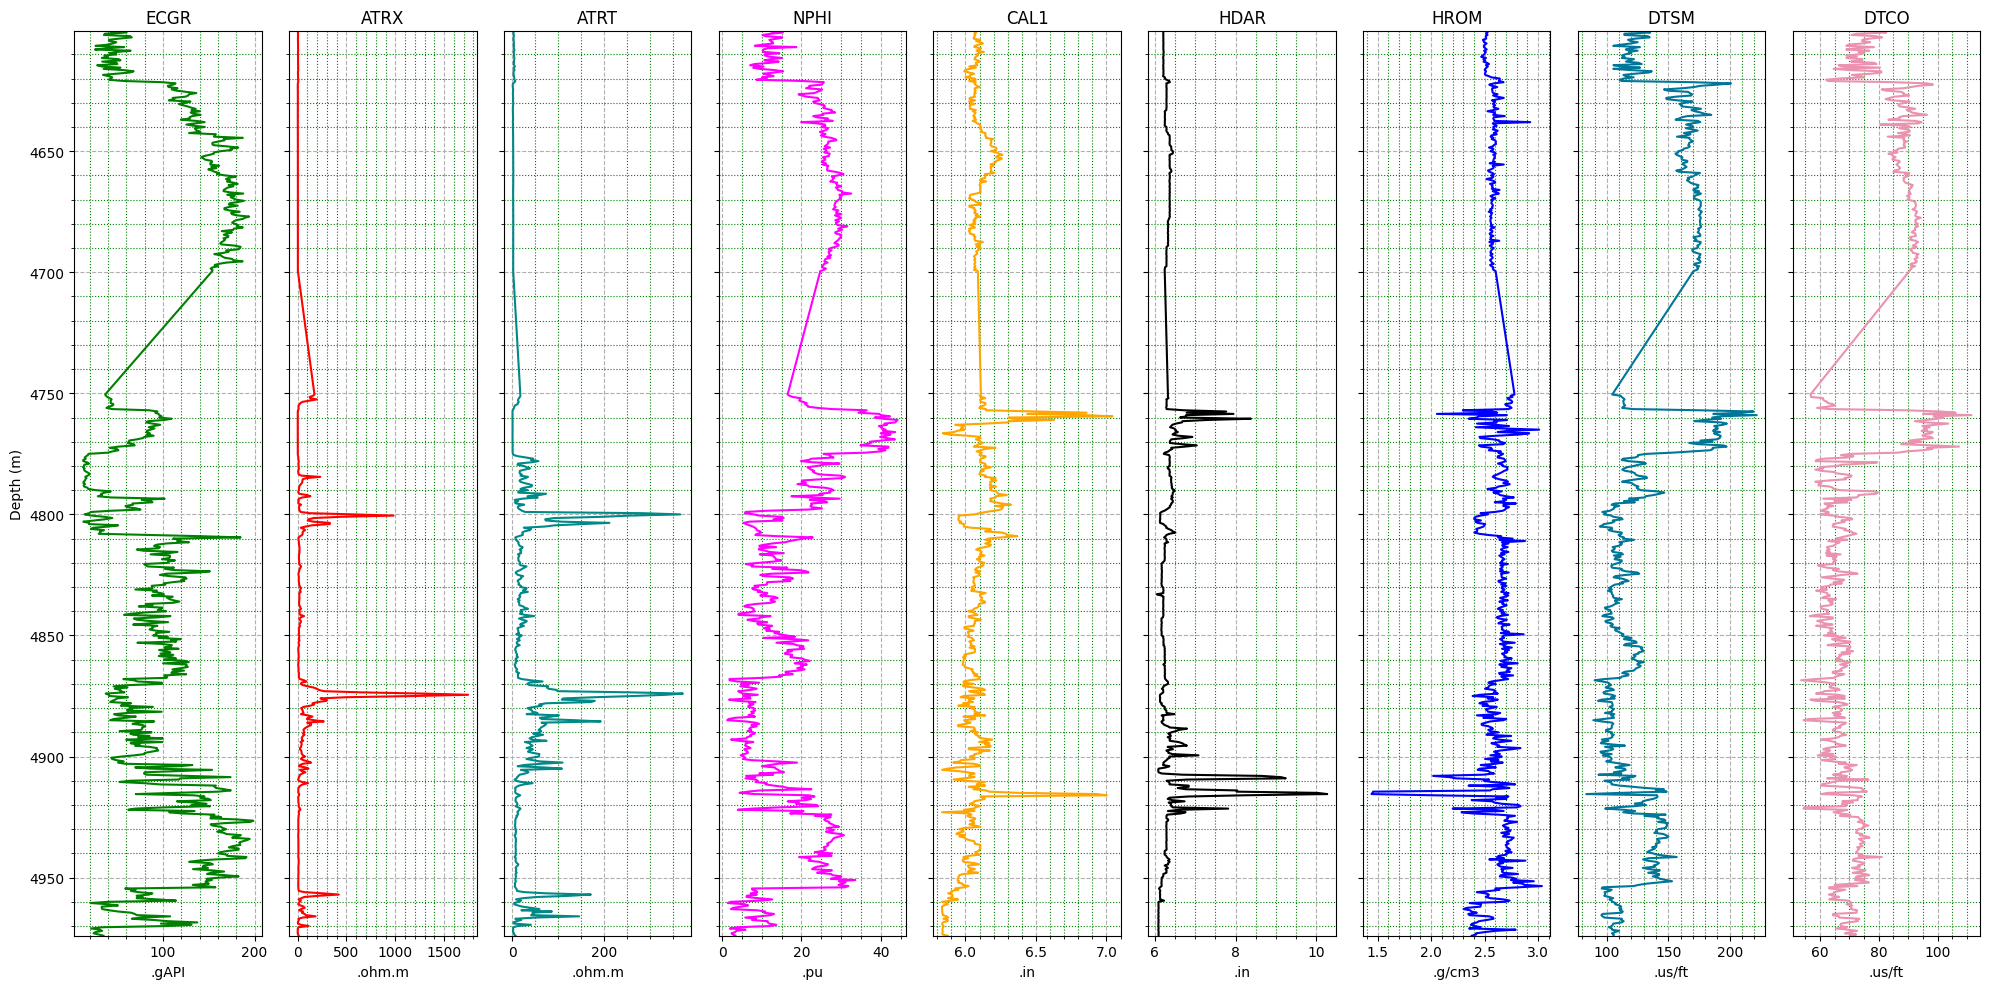

In [28]:
data_train = data.dropna()
plot_log(data_train)

Note that the linear value (see depth >=4700 and <=4750) in the plot above is not from the data. i already remove it using dropna().

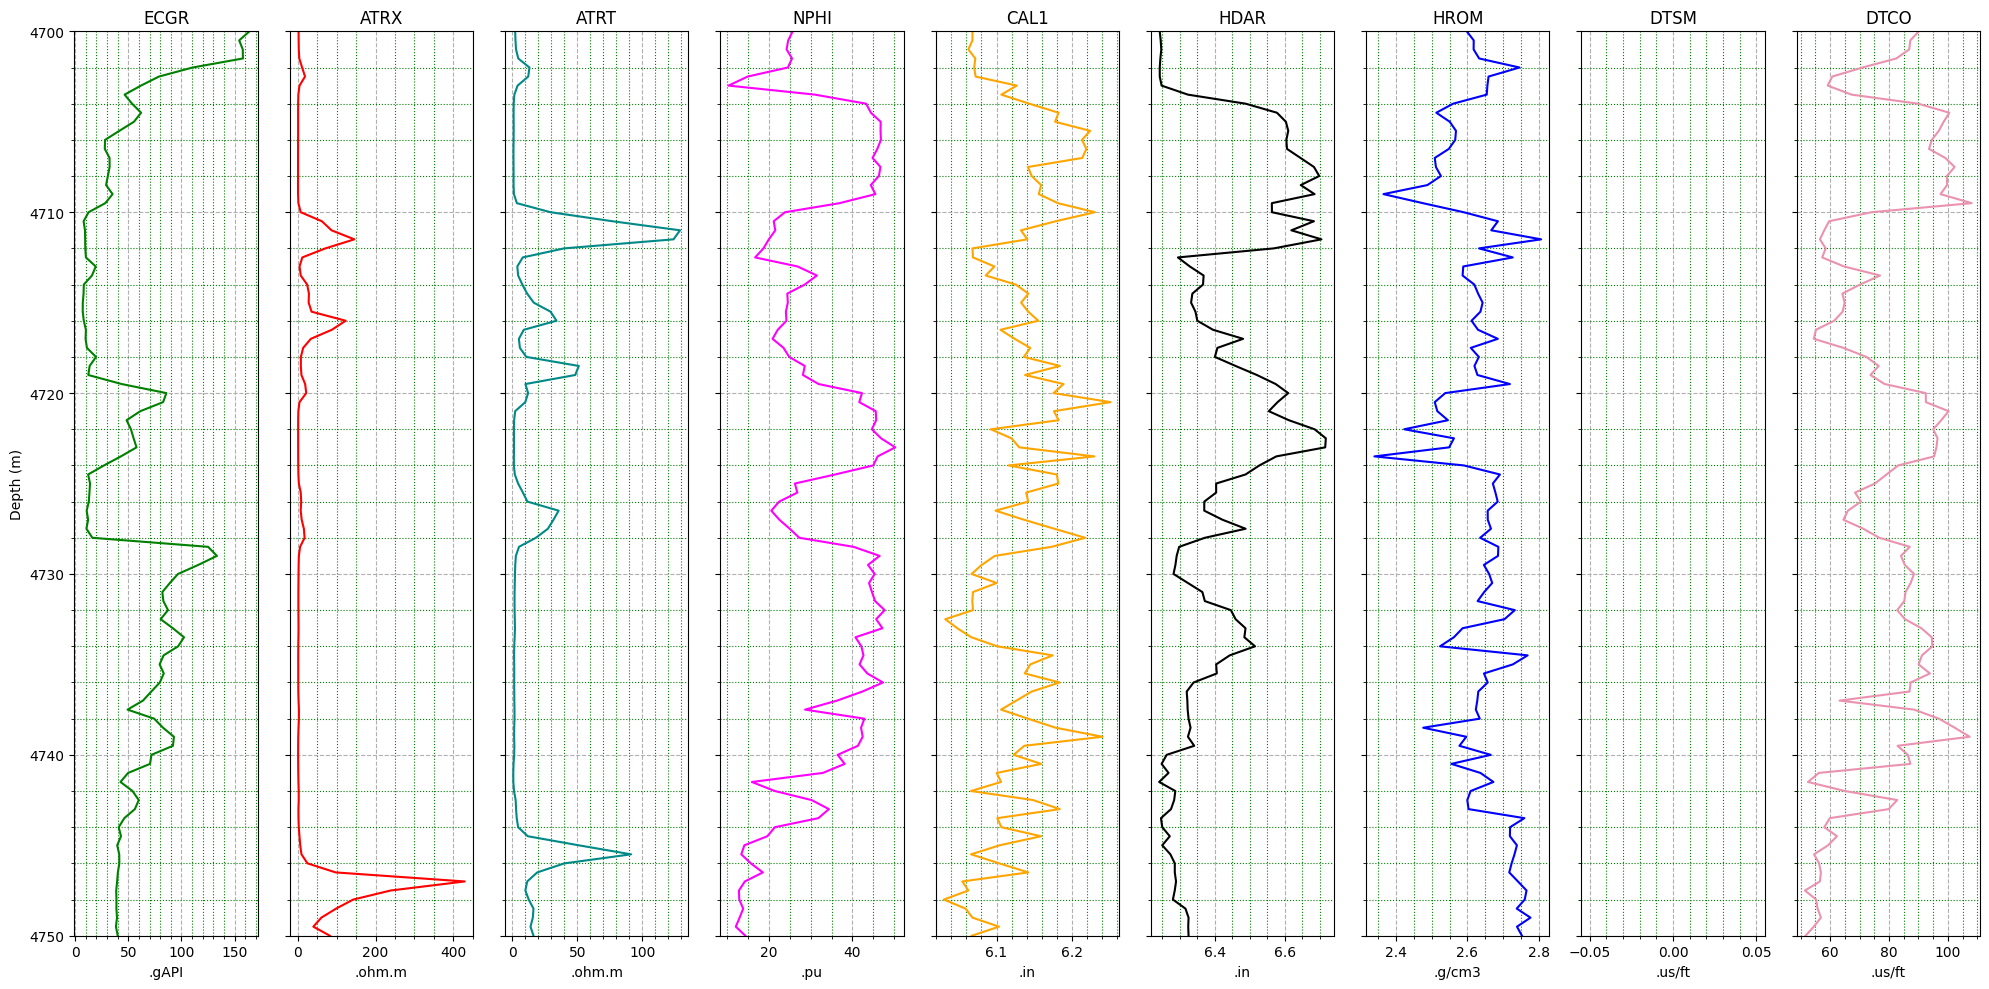

In [29]:
data_test = data[(data['DEPT'] >= 4700) & (data['DEPT'] <= 4750)]
plot_log(data_test)


# Features selection

To predict DTSM logs, it needed to have feature that have correlation with DTSM.<br>
Here we check the correlation of all the logs. 

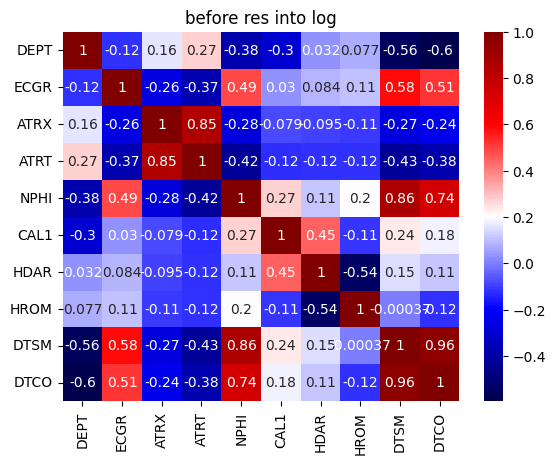

In [30]:
import seaborn as sns
corr = data_train.corr()
plt.title('before res into log')
sns.heatmap(corr, annot=True, cmap='seismic')
plt.show()

In [31]:
# make the resistivity into logarithmic because it can be helpful to see the resistivity in logarithmic value
data_train['ATRT'] = np.log(data_train['ATRT'])
data_train['ATRX'] = np.log(data_train['ATRX'])

/tmp/ipykernel_290524/670055629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['ATRT'] = np.log(data_train['ATRT'])
/tmp/ipykernel_290524/670055629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['ATRX'] = np.log(data_train['ATRX'])


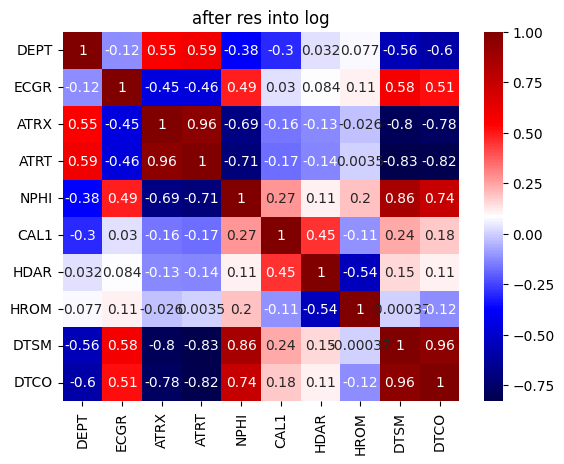

In [32]:
corr = data_train.corr()
plt.title('after res into log')
sns.heatmap(corr, annot=True, cmap='seismic')
plt.show()

In [33]:
dtsm_corr = corr['DTSM']
dtsm_corr = np.abs(dtsm_corr)
dtsm_corr.sort_values(ascending=False)

DTSM    1.000000
DTCO    0.955013
NPHI    0.857481
ATRT    0.829486
ATRX    0.795515
ECGR    0.582898
DEPT    0.557233
CAL1    0.238105
HDAR    0.151819
HROM    0.000370
Name: DTSM, dtype: float64

We can see putting resistivity logs into logarithmic helps with correlation with DTSM log.<br>
So, to predict DTSM we used ATRT and ATRX in logarithmic form.


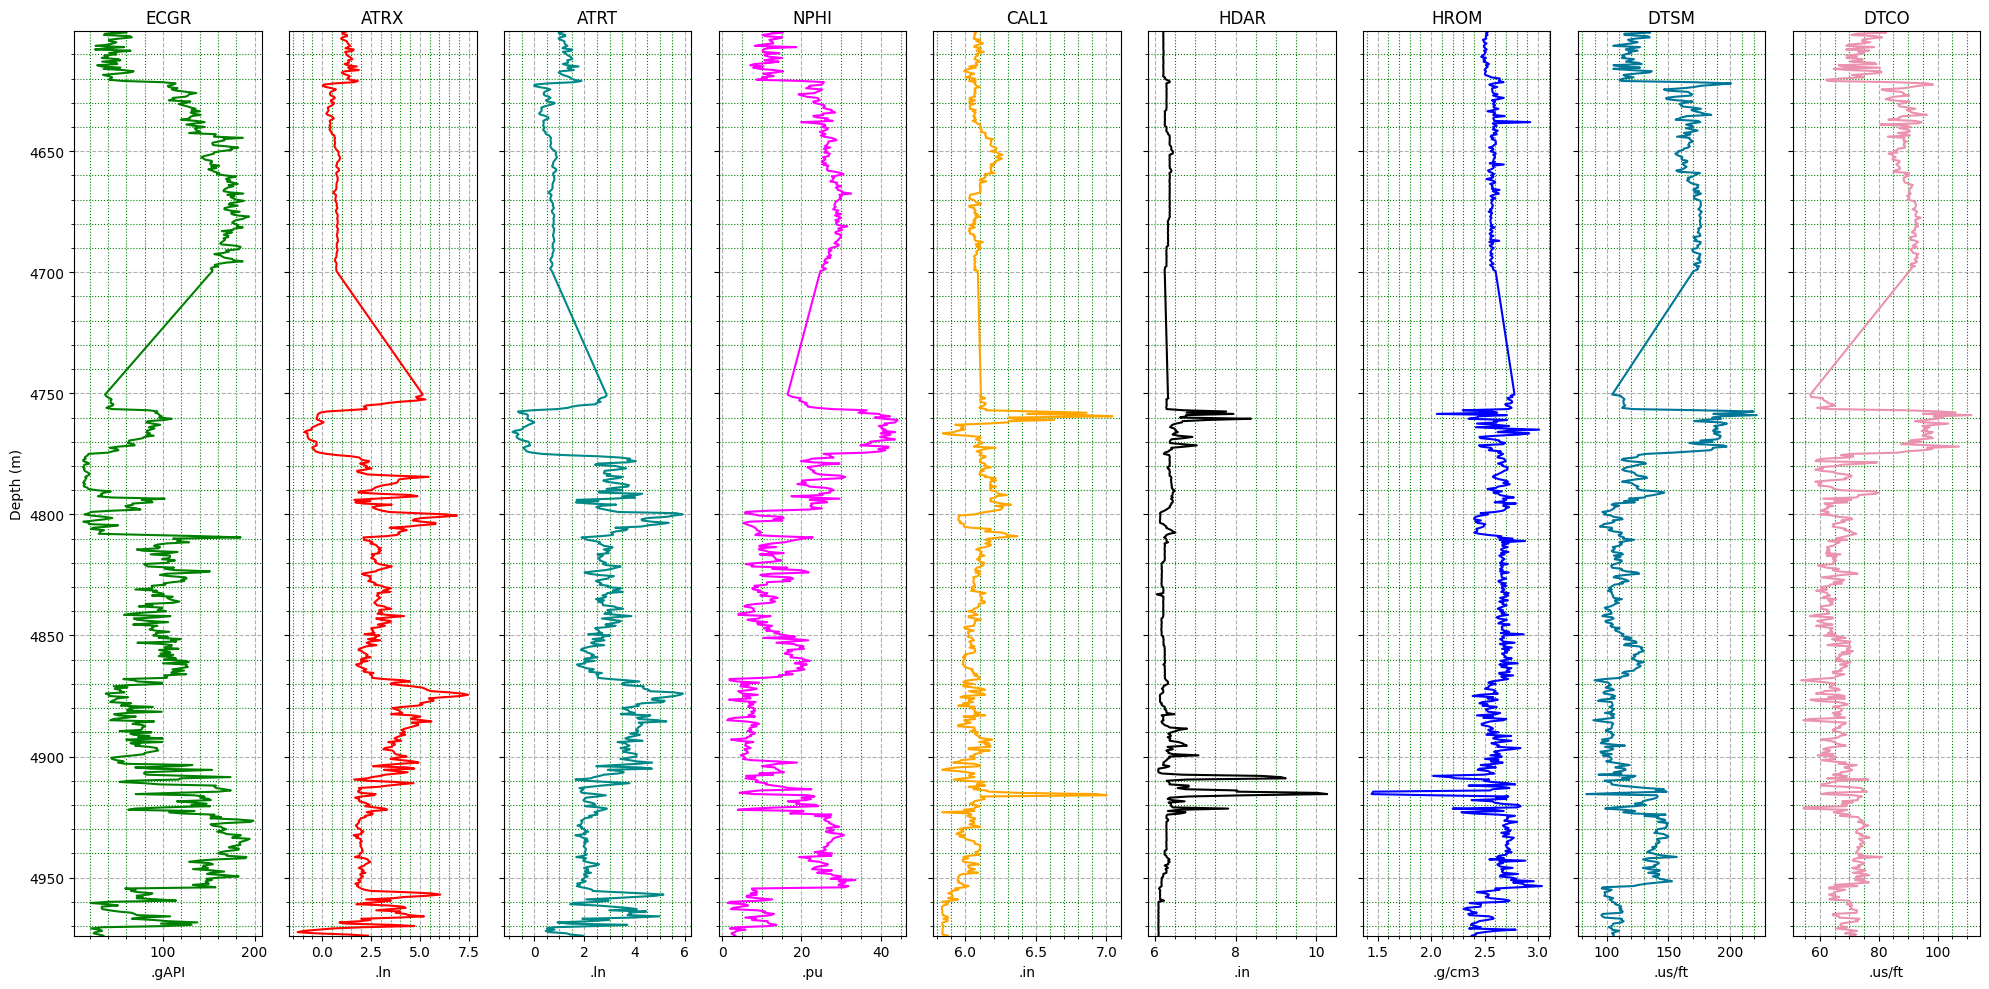

In [34]:
plot_log_res(data_train)


In [35]:
# we can choose the minimum correlation we want. Some says in neural network the least amount of correlation is 0.3.
# in this case i will choose >0.5
dtsm_corr = dtsm_corr[dtsm_corr > 0.5]
dtsm_corr.sort_values(ascending=False)

DTSM    1.000000
DTCO    0.955013
NPHI    0.857481
ATRT    0.829486
ATRX    0.795515
ECGR    0.582898
DEPT    0.557233
Name: DTSM, dtype: float64

Looking back at the correlation matrix.

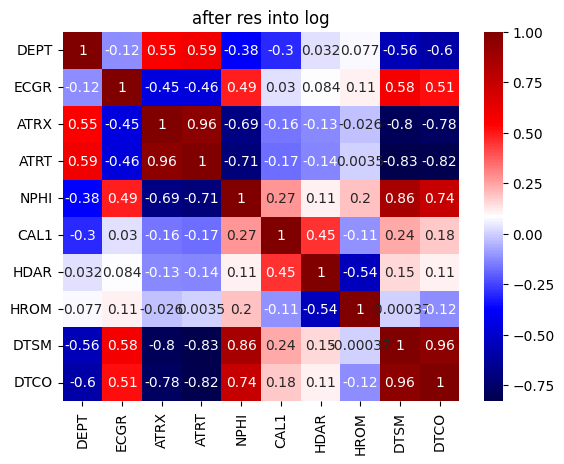

In [36]:
plt.title('after res into log')
sns.heatmap(corr, annot=True, cmap='seismic')
plt.show()

because ATRT and ATRX have a high correlation (0.96), i only choose one of them to predict DTSM to avoid redudancy.
i choose ATRT because it have better correlation with DTSM

From this correlation analysis, we can conclude that the logs that will be used as the features to predict Vs are:
 - DTCO    0.955013
 - NPHI    0.857481
 - ATRT    0.829486
 - ECGR    0.582898
 - DEPT    0.557233

In [37]:
# drop the unnecessary logs from the data
data_train.drop(columns=['ATRX', 'HDAR', 'HROM', 'CAL1'])
data_test.drop(columns=['ATRX', 'HDAR', 'HROM', 'CAL1'])

DEPT      ECGR     ATRT   NPHI  DTSM     DTCO
199  4700.0  163.9813   2.1034  25.75   NaN  90.1399
200  4700.5  154.3376   2.3362  24.68   NaN  87.2373
201  4701.0  157.7082   2.7743  24.30   NaN  86.8458
202  4701.5  157.8475   4.4744  25.60   NaN  82.4820
203  4702.0  110.5298  13.0704  24.61   NaN  70.9861
..      ...       ...      ...    ...   ...      ...
295  4748.0   38.8519  12.5002  13.03   NaN  55.2528
296  4748.5   38.7992  16.1891  13.96   NaN  55.7347
297  4749.0   39.3703  15.6818  13.11   NaN  56.8698
298  4749.5   38.3492  13.8900  12.20   NaN  54.4299
299  4750.0   40.0733  16.1912  14.47   NaN  51.6429

[101 rows x 6 columns]

# Design the architecture of the neural network

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [39]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

X = data_train[['DEPT', 'ECGR', 'ATRT', 'NPHI', 'DTCO']]
y = data_train['DTSM']

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.3, random_state=69) # 70% of the data will be trained and 30% of the data will be used as validation

optimizer = Adam(learning_rate=0.001)


print(f'X train shape: {Xtrain.shape}')
print(f'X validation shape: {Xval.shape}')
print(f'y train shape: {ytrain.shape}')
print(f'y validation shape: {yval.shape}')

X train shape: (452, 5)
X validation shape: (195, 5)
y train shape: (452,)
y validation shape: (195,)


In [40]:
# because of neural network is a gradient based machine learning, the value of the feature needed to be in the same scale to ensure the the influence from each feature is the same.
# looking at the distribution of the data(i checked it with data wrangler), it is not a normal distribution so i choose RobustScaler to do the job
scaler = RobustScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)

# Model training and evaluation

In [41]:
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')

from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Input(shape=(5,)))
model.add(Dense(128,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.fit(x=Xtrain, y=ytrain,
          validation_data=(Xval, yval),
          batch_size=16,
          epochs=1000,
          callbacks=[early_stop])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 18169.9727 - val_loss: 17815.4688
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18220.3438 - val_loss: 16332.8242
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15541.7168 - val_loss: 12758.1240
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ -2s -74899us/step - loss: 11881.3584 - val_loss: 7012.5303
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5836.3281 - val_loss: 2082.2249
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1635.3093 - val_loss: 797.8401
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 792.7398 - val_loss: 569.2774
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 633.3306 - val_loss: 410.1677
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 386.8721 - val_loss: 307.5619
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 320.4530 - val_loss: 232.3882
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 227.8883 - va

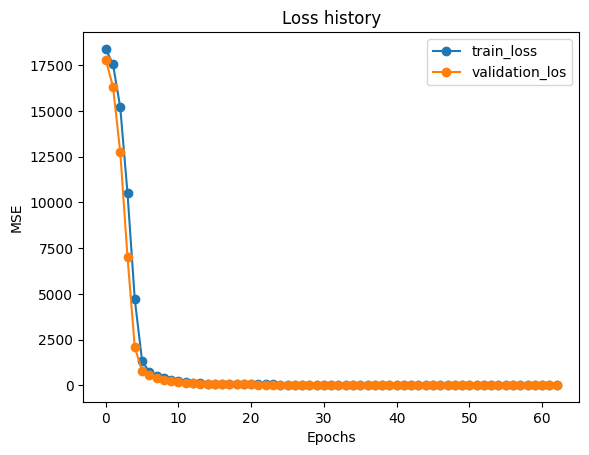

In [42]:
losses = pd.DataFrame(model.history.history)
# losses.head()
plt.plot(losses['loss'], label='train_loss', marker='o')
plt.plot(losses['val_loss'], label='validation_los', marker='o')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Predicting the validation dataset

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[]

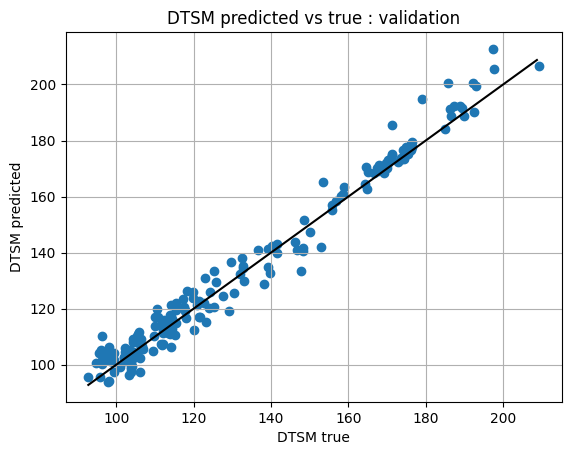

In [43]:
yval_pred = model.predict(Xval)


yval_plot = np.arange(min(yval), max(yval))

plt.scatter(yval, yval_pred)
plt.plot(yval_plot, yval_plot, c='black')

plt.ylabel('DTSM predicted')
plt.xlabel('DTSM true')
plt.title('DTSM predicted vs true : validation')
plt.grid()
plt.plot()

In [44]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
r2 = r2_score(yval, yval_pred)
mse = mean_squared_error(yval, yval_pred)
rmse = root_mean_squared_error(yval, yval_pred)
mae = mean_absolute_error(yval, yval_pred)
print(f'R2 score    :{r2}')
print(f'MSE         :{mse}')
print(f'RMSE        :{rmse}')
print(f'MAE         :{mae}')

R2 score    :0.9745486656673816
MSE         :23.7357529973191
RMSE        :4.8719352414948105
MAE         :3.694421849208734


# Predicting the missing DTSM

In [45]:
data_test['ATRT'] = np.log(data_test['ATRT'])
data_test['ATRX'] = np.log(data_test['ATRX'])

/tmp/ipykernel_290524/3567512311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['ATRT'] = np.log(data_test['ATRT'])
/tmp/ipykernel_290524/3567512311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['ATRX'] = np.log(data_test['ATRX'])


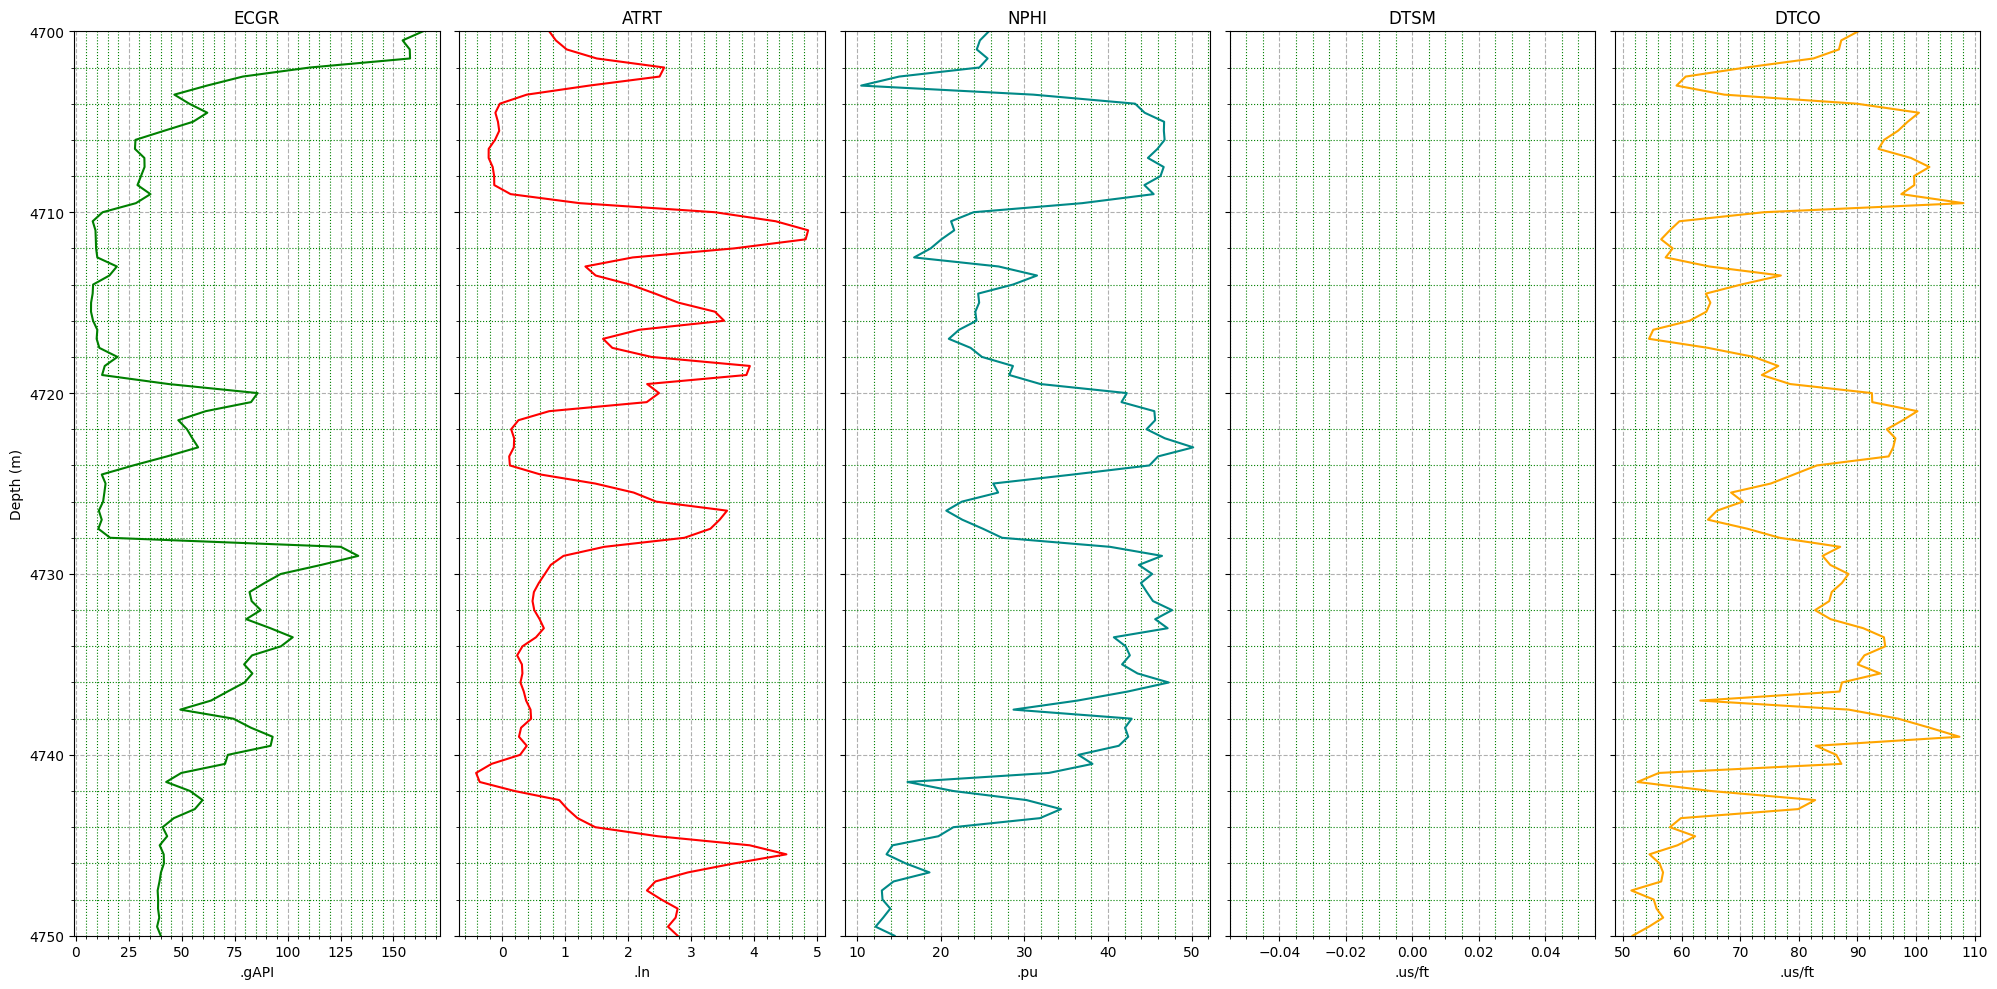

In [46]:
from plot import plot_train, plot_test, plot_features
data_test = data_test.drop(columns=['ATRX', 'HDAR', 'HROM', 'CAL1'])

plot_test(data_test)

In [47]:
Xtest = data_test.drop(columns=['DTSM'] )
Xtest.head()

DEPT      ECGR      ATRT   NPHI     DTCO
199  4700.0  163.9813  0.743555  25.75  90.1399
200  4700.5  154.3376  0.848526  24.68  87.2373
201  4701.0  157.7082  1.020398  24.30  86.8458
202  4701.5  157.8475  1.498372  25.60  82.4820
203  4702.0  110.5298  2.570350  24.61  70.9861

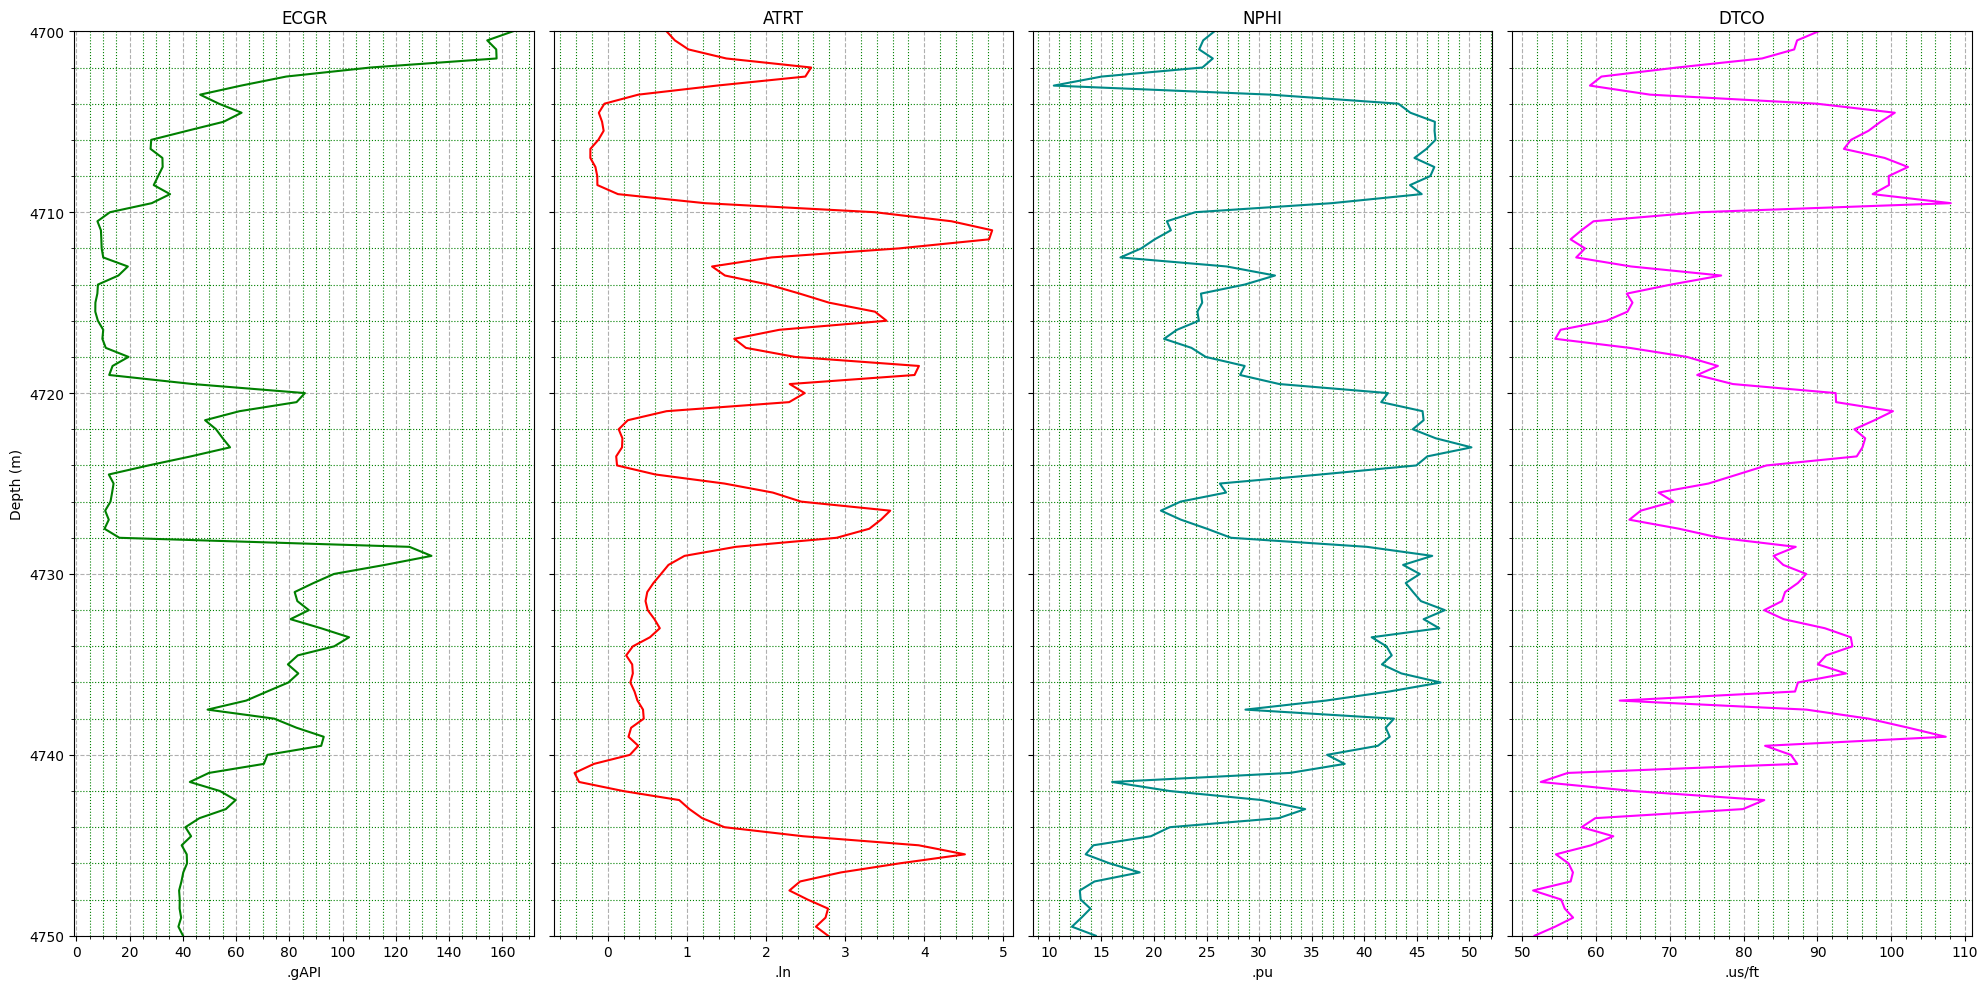

In [48]:
plot_features(Xtest)

In [49]:
Xtest = scaler.transform(Xtest)
ypred = model.predict(Xtest)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


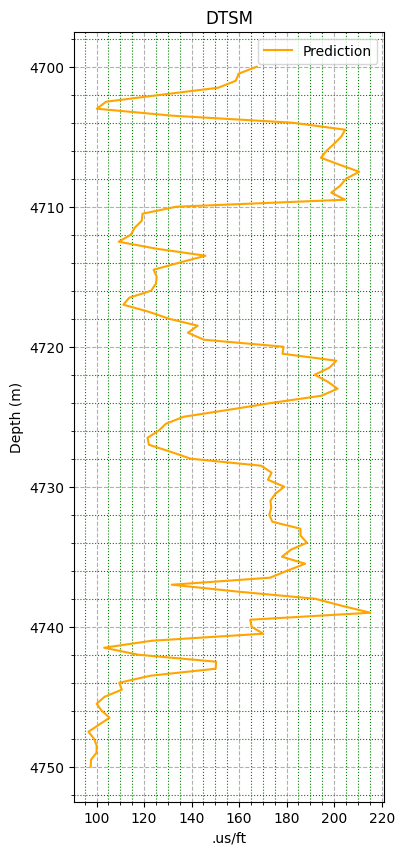

In [50]:
plt.figure(figsize=(4, 10))
# plt.plot(DTSM_true, data_interest['DEPT'],  label = 'True')
plt.plot(ypred, data_test['DEPT'], label='Prediction', color='orange')
plt.ylabel('Depth (m)')
plt.xlabel('.us/ft')
plt.title('DTSM')
plt.legend()
plt.grid()
plt.grid(linestyle='--')
plt.grid(which='minor', linestyle=':', color='green')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.show()

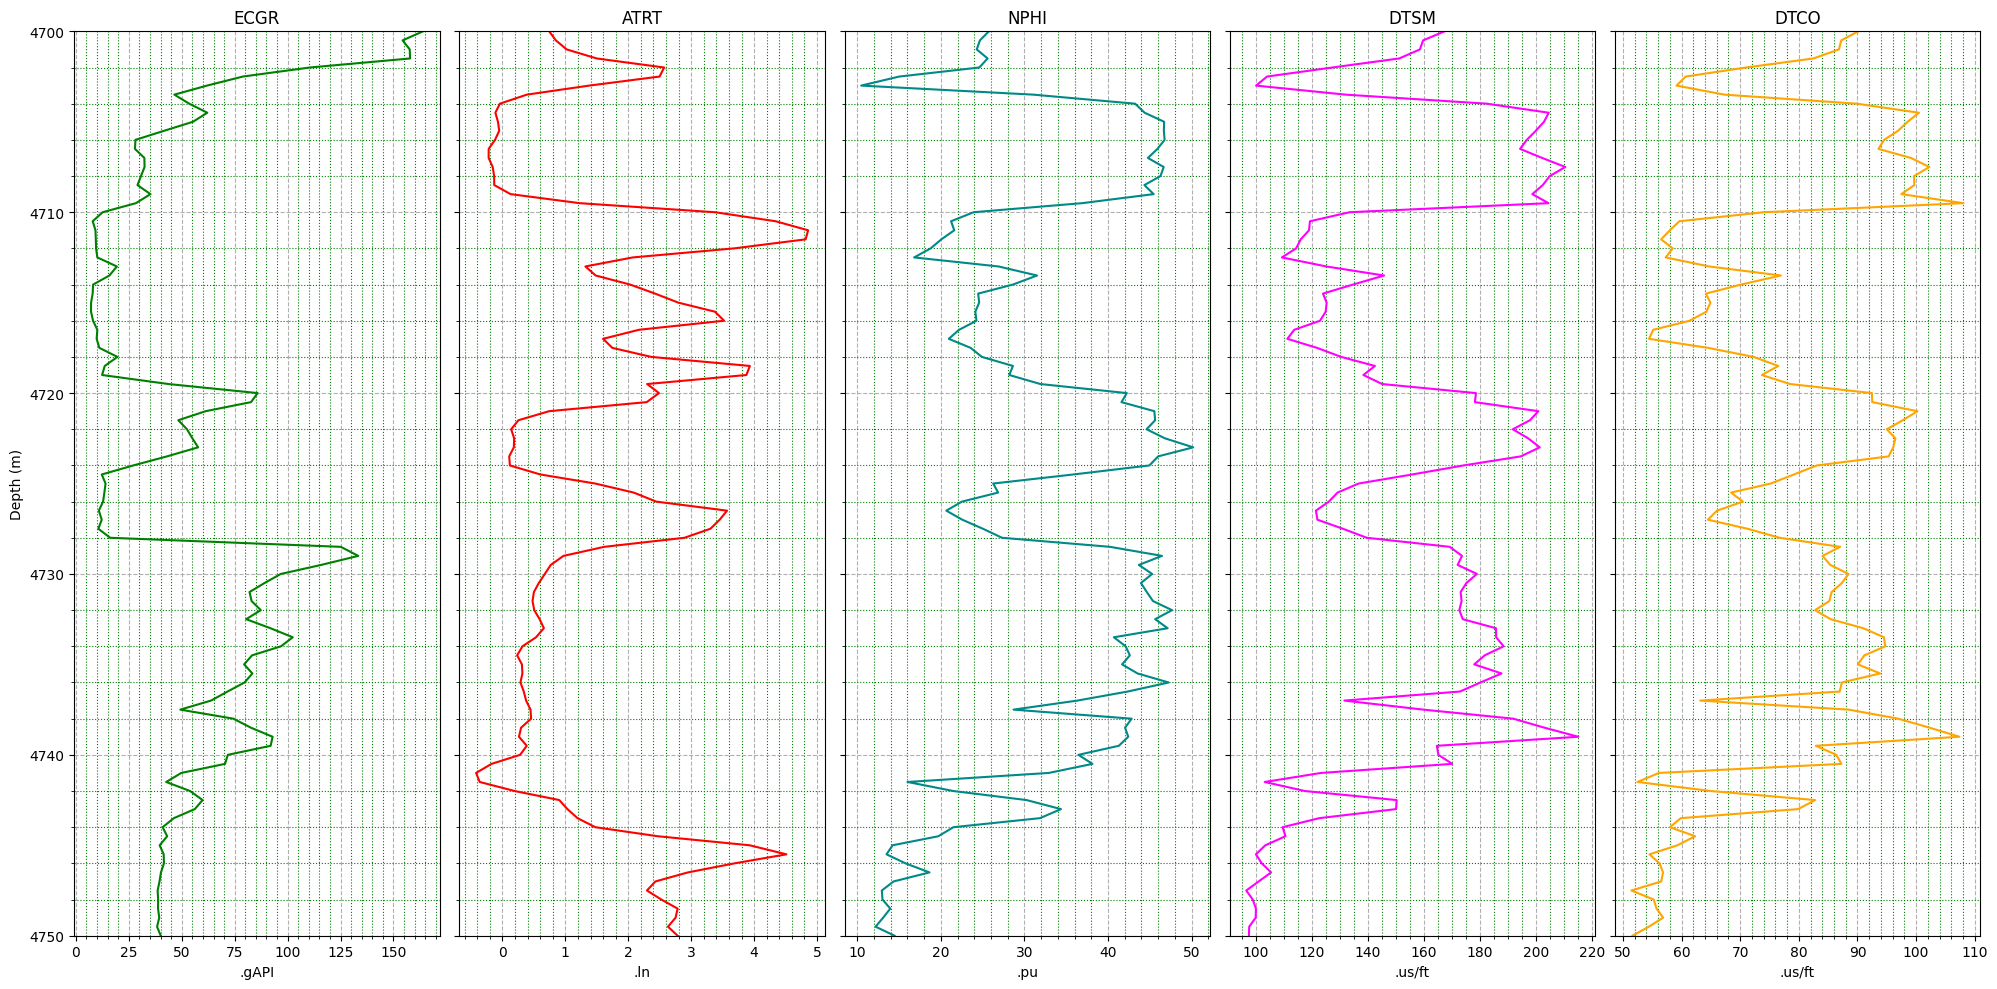

In [51]:
from plot import plot_log_res
data_test['DTSM'] = ypred
plot_test(data_test)

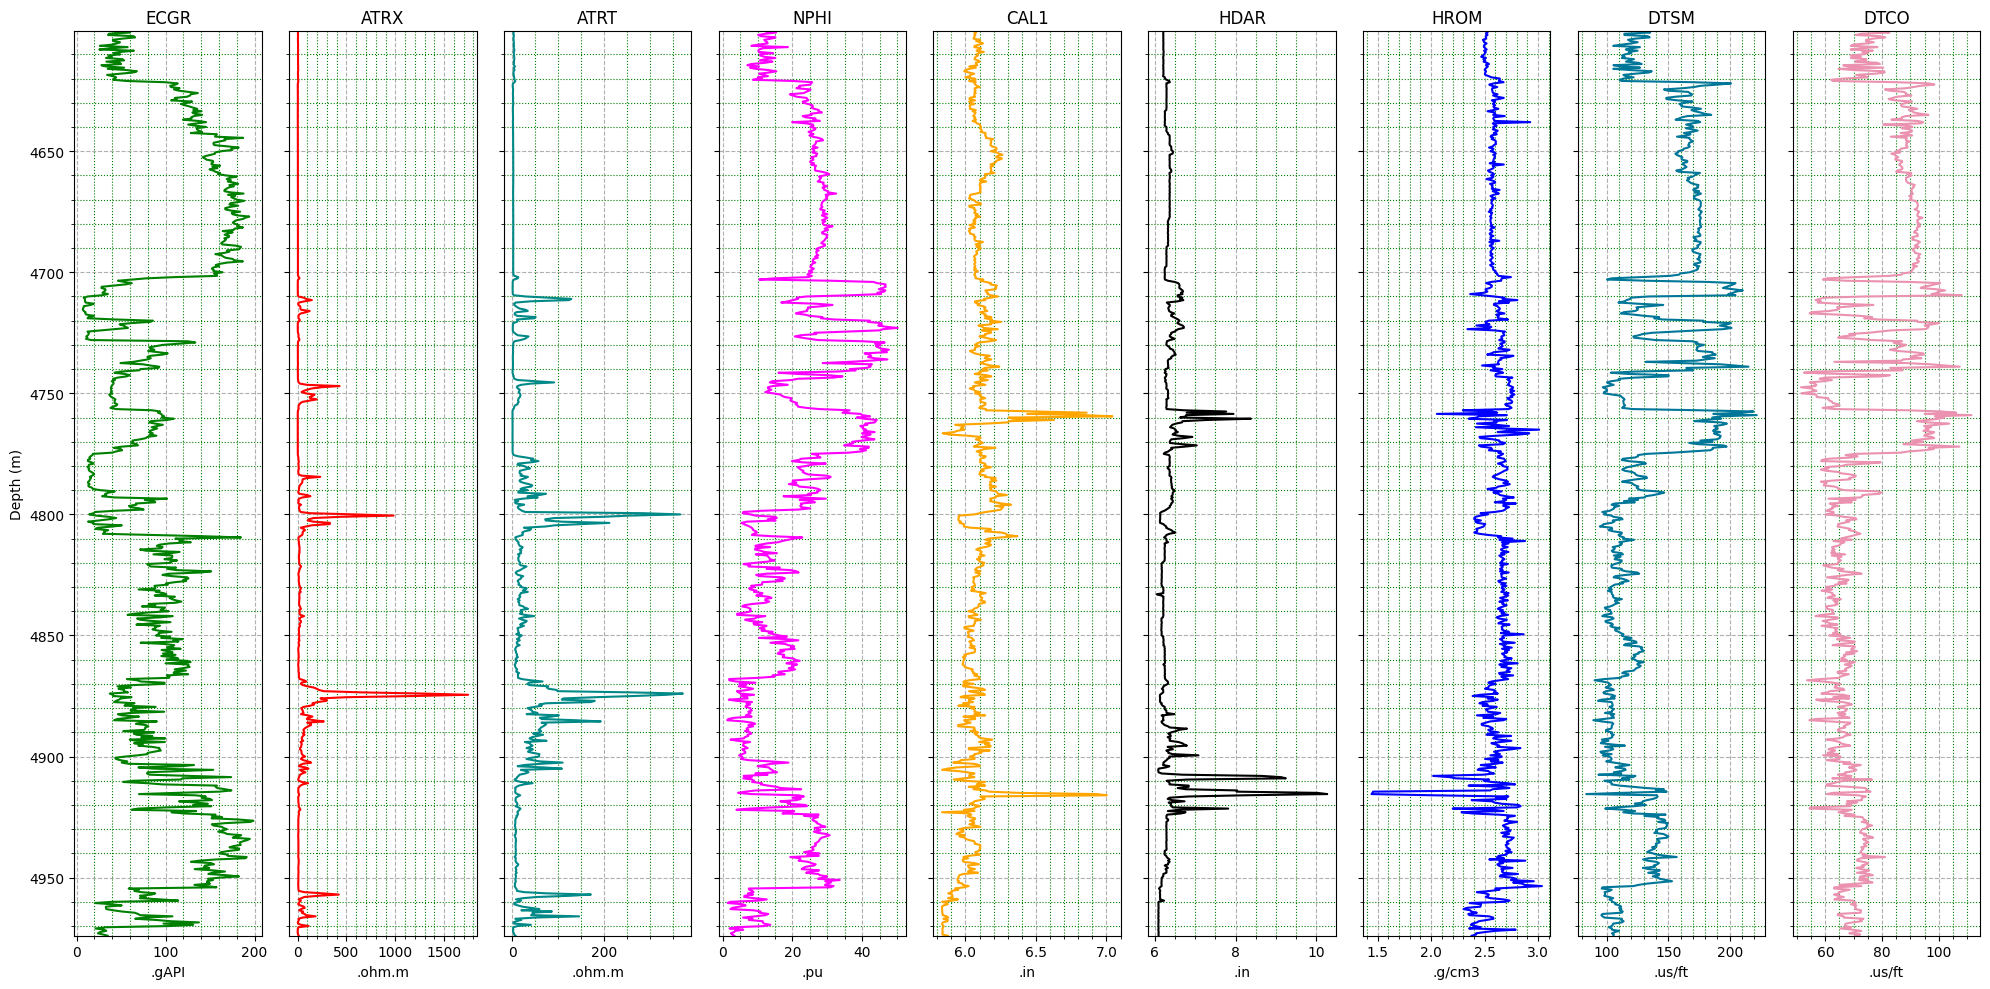

In [52]:
data_wtih_prediction = data.copy()
missing_depth_dtsm = (data_wtih_prediction['DEPT'] >= 4700) & (data_wtih_prediction['DEPT'] <= 4750)
dtsm_array = data_wtih_prediction.loc[missing_depth_dtsm, 'DTSM'].values
data_wtih_prediction['DTSM'] = np.nan_to_num(data_wtih_prediction['DTSM'], nan=0)

data_wtih_prediction.loc[missing_depth_dtsm, 'DTSM'] = ypred
plot_log(data_wtih_prediction)

In [53]:
# save it into csv
data_wtih_prediction.to_csv('data with prediction.csv', index=False)

# Bonus : we have the chance to get the test score of the model!

In [54]:
data_full = pd.read_csv('../ML-Vs-prediction-main/data/true_data_from_friend.csv')
data_full[data_full == -999.250] = np.nan
data_full = data_full.dropna()
data_full.head()

DEPT     ECGR    ATRX    ATRT   NPHI    CAL1    HDAR    HROM      DTSM  \
0  4600.5  42.8228  3.5445  3.2769  12.40  6.0635  6.2070  2.5112  132.6781   
1  4601.0  60.1452  2.7997  2.6506  15.30  6.0765  6.2088  2.5277  135.1772   
2  4601.5  36.4007  2.8454  2.7274  12.28  6.0627  6.2070  2.5127  114.1906   
3  4602.0  35.3279  3.5764  3.4379  10.16  6.0711  6.2088  2.5271  114.2432   
4  4602.5  64.0310  3.5706  3.4355  10.93  6.0625  6.2088  2.5094  133.2964   

      DTCO  
0  80.4120  
1  82.5646  
2  72.5366  
3  70.7520  
4  79.0781

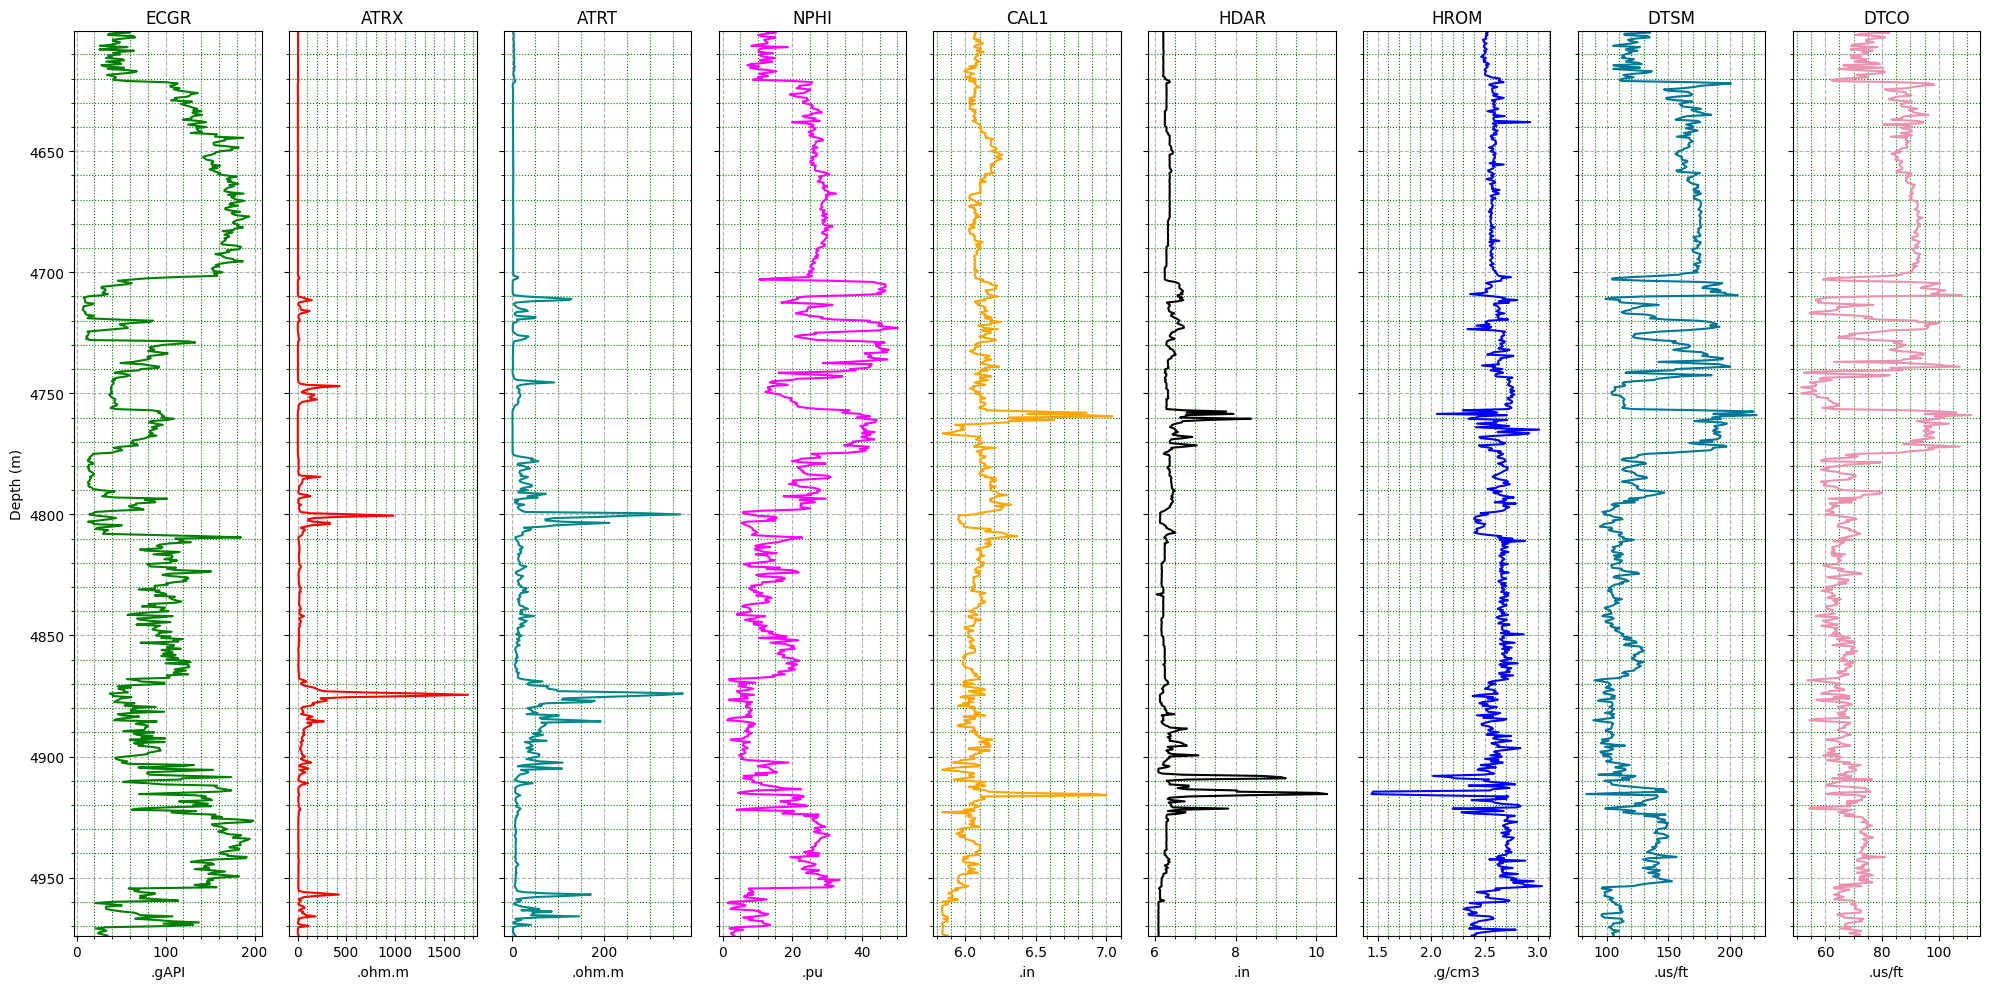

In [55]:
plot_log(data_full)

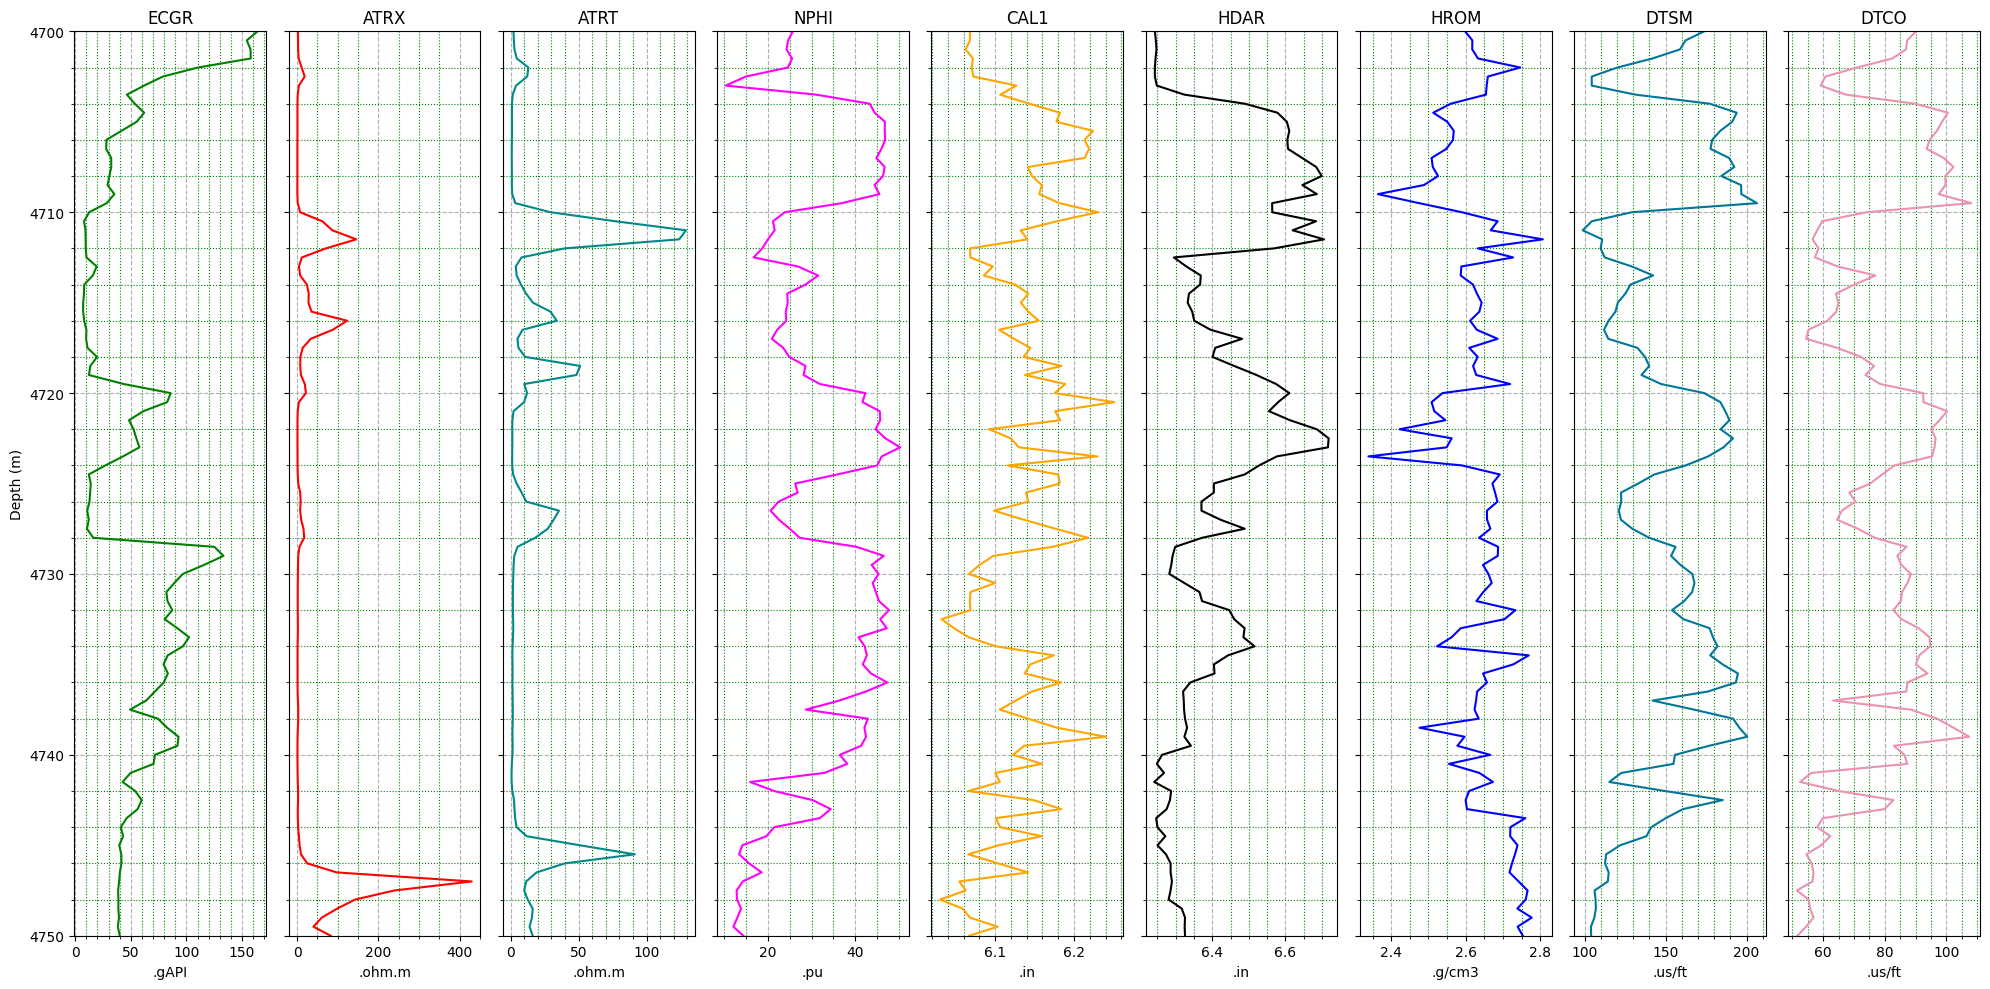

In [56]:
data_full_interest = data_full[(data_full['DEPT'] >=4700) & (data_full['DEPT'] <=4750)]
plot_log(data_full_interest)

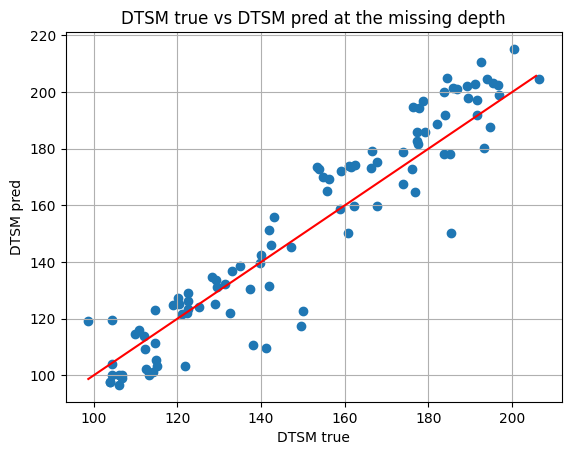

In [57]:
DTSM_true = data_full_interest['DTSM']
DTSM_pred = ypred
tru = np.arange(min(DTSM_true), max(DTSM_true))
plt.scatter(DTSM_true, DTSM_pred)
plt.plot(tru, tru, color='red')
plt.xlabel('DTSM true')
plt.ylabel('DTSM pred')
plt.title('DTSM true vs DTSM pred at the missing depth')
plt.grid()
plt.show()

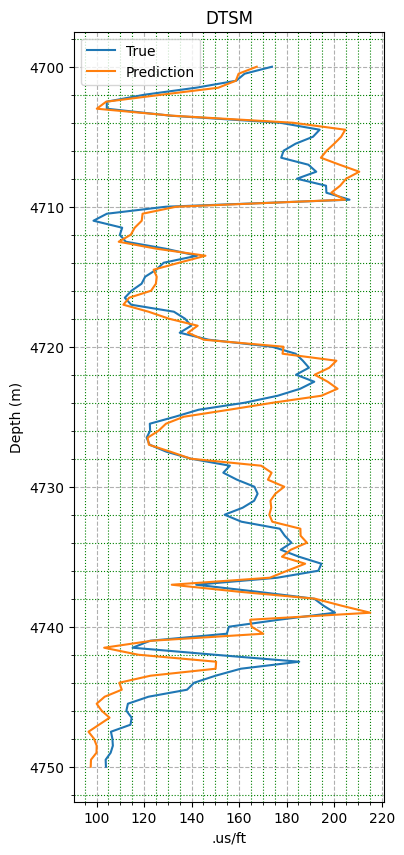

In [58]:
plt.figure(figsize=(4, 10))
plt.plot(DTSM_true, data_test['DEPT'],  label = 'True')
plt.plot(DTSM_pred, data_test['DEPT'], label='Prediction')
plt.ylabel('Depth (m)')
plt.xlabel('.us/ft')
plt.title('DTSM')
plt.legend()
plt.grid()
plt.grid(linestyle='--')
plt.grid(which='minor', linestyle=':', color='green')
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.show()

In [59]:
r2_fin = r2_score(DTSM_true, DTSM_pred)
mse_fin = mean_squared_error(DTSM_true, DTSM_pred)
rmse_fin = root_mean_squared_error(DTSM_true, DTSM_pred)
mae_fin = mean_absolute_error(DTSM_true, DTSM_pred)


print(f'R2 score    :{r2_fin}')
print(f'MSE         :{mse_fin}')
print(f'RMSE        :{rmse_fin}')
print(f'MAE         :{mae_fin}')

R2 score    :0.8537299210583904
MSE         :139.4781797030317
RMSE        :11.81008804806432
MAE         :9.368451457954633


## Summary
In this notebook, we implemented and trained a neural network to predict DTSM. The results indicate that the model achieved a score of :<br> 
- R2 score    :0.8537299210583904
- MSE         :139.4781797030317
- RMSE        :11.81008804806432
- MAE         :9.368451457954633

## Next Steps
- Optimize hyperparameters to improve performance.
- Experiment with additional features or datasets.
- Implement more advanced models, such as LSTM or GRU since the problem is sequential geology (well log).
- Share the trained model or integrate it into an application.
